# MULTIVARIATE FORECASTING USING SIMPLE & DEEP RECURRENT NEURAL NETWORKS

_**Multivariate time-series forcasting using Simple & Deep Recurrent Neural Networks (RNNs).**_

The following experiment considers Chicago Transit Authority (CTA) dataset (https://data.cityofchicago.org/) containing daily bus and rail ridership. The data from January 01, 2001 through August 1, 2024 was considered in this experiment.

In [1]:
# Imports required packages

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-12-04 07:22:59.022757: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-04 07:22:59.023037: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 07:22:59.058233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 07:22:59.908140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Retrieving Data

In [2]:
# Loads the dataset
ridership = pd.read_csv(
    "./../data/CTA-Ridership-Daily_Boarding_Totals_20240829.csv", 
    parse_dates=["service_date"]  # To consider column as a date coumn if it contains date represented as text
)

# Shows the dataset
display(ridership)

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343
...,...,...,...,...,...
8578,2024-04-26,W,554146,355278,909424
8579,2024-04-27,A,419731,286199,705930
8580,2024-04-28,U,293589,196481,490070
8581,2024-04-29,W,556233,349857,906090


Note: Attribute value **W**, **A** ans **U** in column **day_type** represent **Weekday**, **Saturday** and **Sunday/Holiday**, respectively.

In [3]:
# Sets the column 'service_date' as index
ridership.set_index("service_date", inplace=True)

In [4]:
# Sorts dataset (in ascending order) by index "service_date" to make index monotonic considering
# it would be a requirement for slicing DataFrame with a datetime type based index
ridership.sort_index(inplace=True)

In [5]:
# Drops the calculated column "total_rides" as this is just element-wise addition 
# between columns "bus" and "rail_boardings".
ridership.drop("total_rides", axis=1, inplace=True)

## Data Analysis

<Axes: xlabel='service_date'>

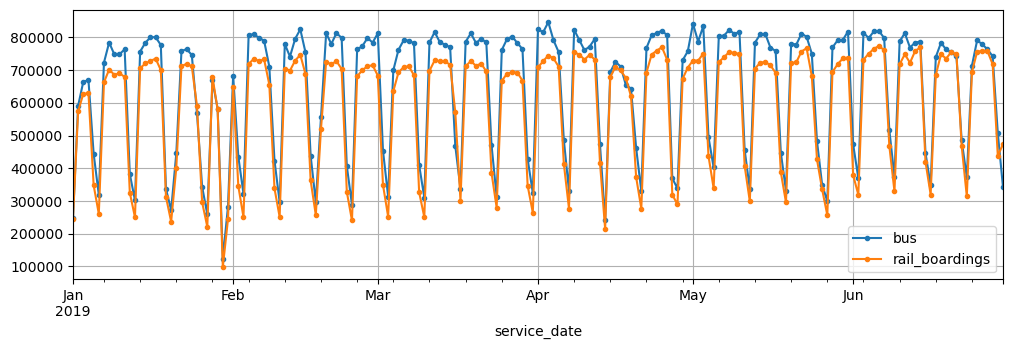

In [6]:
# Plots the bus and rail ridership over a few months in 2019
ridership["2019-01":"2019-06"].plot(grid=True, marker=".", figsize=(12, 3.5))

Weekly seasonality (repeating pattern) for both variables - bus and rail was observed by looking at the above figure.

## Data Preprocessing

**Prepares Datasets for Modeling**

Prepares dataset with multiple features as input for modeling

In [7]:
ridership_multivar = ridership[["bus", "rail_boardings"]] / 1e6

# Considering next day could affect the present day's ridership, it
# creates a feature indicating the next day (as type 'W', 'A' and 'U')
ridership_multivar["next_day_type"] = ridership["day_type"].shift(-1)

# Encodes text type attribute into using one-hot (integer) encoding
ridership_multivar = pd.get_dummies(ridership_multivar, dtype=int)

# Shows the encoded multivariate dataset
display(ridership_multivar)

,bus,rail_boardings,next_day_type_A,next_day_type_U,next_day_type_W
service_date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
...,...,...,...,...,...
2024-04-26,0.554146,0.355278,1,0,0
2024-04-27,0.419731,0.286199,0,1,0
2024-04-28,0.293589,0.196481,0,0,1


In [8]:
# Checks the shape of the multivariate dataset
ridership_multivar.shape

(8583, 5)

The above dataset is a DataFrame with five columns: 'bus', 'rail_boardings', plus three columns containing encoded values for next day.

In [9]:
# Splits the time-series into three periods - for training, validation and testing

multivar_train = ridership_multivar["2016-01":"2018-12"]  # 3 years
multivar_val = ridership_multivar["2019-01":"2019-06"]    # 6 months
multivar_test = ridership_multivar["2019-06":]            # remaining period from 2019-06 through 2024-04

In [10]:
# Prepares TensorFlow specific datasets

seq_length = 56    # sequence of 56 days of ridership data on which prediction for next day is made on

tf.random.set_seed(42)

train_set = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(),                              # All consecutive data points (timesteps) converted from series to array
    targets=multivar_train["rail_boardings"][seq_length:],  # To set targets[i+seq_length]` as target corresponding to the window that starts at index `i`
    sequence_length=seq_length,                             # Length of output sequence
    batch_size=32,                                          # Number of sequences in each batch
    shuffle=True,                                           # Shuffles the output sequences [required only for training]
    seed=42                                                 # Random seed for shuffling [required only if shuffling is set to True]
)

val_set = tf.keras.utils.timeseries_dataset_from_array(
    multivar_val.to_numpy(),
    targets=multivar_val["rail_boardings"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

test_set = tf.keras.utils.timeseries_dataset_from_array(
    multivar_test.to_numpy(),
    targets=multivar_test["rail_boardings"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

2025-12-04 07:23:00.695569: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Modeling
_Forecasting next days's rail ridership based (only) on rail ridership [multiple variables as input] of the past 8 weeks (56 days) using simple and deep RNNs._

### Multivariate Forecasting using a Single RNN

In [11]:
# Resets all the keras states
tf.keras.backend.clear_session()

tf.random.set_seed(42)

# Creates an RNN with 32 recurrent neurons followed by a dense output layer with one output neuron
# The same model was used before for univariate forecasting, but it is now being used for multivariate forecasting
multivar_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),  # Now, model accepts 5 inputs
    tf.keras.layers.SimpleRNN(32),   
    tf.keras.layers.Dense(1)
])

In [12]:
# Compiles it with specific loss function, optimizer and metric
multivar_simple_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=["mae"])

In [14]:
# Fits the model
history = multivar_simple_rnn.fit(
    train_set, 
    validation_data=val_set, 
    epochs=500, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0275 - mae: 0.1669 - val_loss: 0.0019 - val_mae: 0.0521
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - mae: 0.0520 - val_loss: 0.0014 - val_mae: 0.0411
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mae: 0.0425 - val_loss: 8.9383e-04 - val_mae: 0.0316
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016 - mae: 0.0391 - val_loss: 6.7975e-04 - val_mae: 0.0256
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - mae: 0.0379 - val_loss: 0.0013 - val_mae: 0.0405
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 0.0014 - val_mae: 0.0450
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - mae: 0.0382 - val_loss: 0.0013 - val_mae: 0.0425
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - mae: 0.0365 - val_loss: 9.9262e-04 - val_mae: 0.0343
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13

In [16]:
# After training, model gets evaluated against validation data

val_loss, val_mae = multivar_simple_rnn.evaluate(val_set)

print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the multivariate simple RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0401e-04 - mae: 0.0233 

Validation loss: 604.0063, MAE of the multivariate simple RNN: 23270.6070


Validation MAE for multivariate simple RNN is 23270 where the the same performance was 29316 for its univariate counterpart.

### Multivariate Forecasting using a Deep RNN

In [19]:
tf.keras.backend.clear_session()    # Resets all the keras states

tf.random.set_seed(42)

multivar_deep_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),  # Now, model accepts 5 inputs
    tf.keras.layers.SimpleRNN(32, return_sequences=True),   
    tf.keras.layers.SimpleRNN(32, return_sequences=True),   
    tf.keras.layers.SimpleRNN(32),   
    tf.keras.layers.Dense(1)
])

In [20]:
# Compiles the model
multivar_deep_rnn.compile(
    loss="huber",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["mae"])

In [22]:
# Fits the model
history = multivar_deep_rnn.fit(
    train_set, 
    validation_data=val_set, 
    epochs=500, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    ])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0127 - mae: 0.1129 - val_loss: 0.0032 - val_mae: 0.0658
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - mae: 0.0510 - val_loss: 0.0032 - val_mae: 0.0709
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - mae: 0.0464 - val_loss: 0.0017 - val_mae: 0.0469
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0480 - val_loss: 0.0052 - val_mae: 0.0954
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - mae: 0.0536 - val_loss: 9.8446e-04 - val_mae: 0.0336
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mae: 0.0499 - val_loss: 0.0011 - val_mae: 0.0348
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - mae: 0.0414 - val_loss: 0.0030 - val_mae: 0.0702
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - mae: 0.0443 - val_loss: 7.4894e-04 - val_mae: 0.0270
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

In [23]:
# After training, model gets evaluated against validation data

val_loss, val_mae = multivar_deep_rnn.evaluate(val_set)

print(f"\nValidation loss: {val_loss * 1e6:.4f}, MAE of the multivariate deep RNN: {val_mae * 1e6:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2765e-04 - mae: 0.0240 

Validation loss: 627.6468, MAE of the multivariate deep RNN: 23979.1758


Validation MAE for multivariate deep RNN is 23979 where the the same performance was 27966 for its univariate counterpart.

## Observations

- Simple RNN based multivariate model performed better with MAE of 23270 compared to that of its univariate counterpart that scored MAE of 29316 (refer to the univariate modeling notebook).

- On the other hand, deep RNN based multivariate model performed better with MAE of 23979 compared to that of its univariate counterpart that scored MAE of 27966.

- So, as far this dataset is concerned, modeling with more than one relevant features will yield better performance.